<a href="https://colab.research.google.com/github/ddovidovich/DataScienceLerning/blob/main/UNIT_09_DZ_Ultra_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Ознакомьтесь с датасетом образцов эмоциональной речи

    **Toronto emotional speech set (TESS)**:

    https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/E8H2MF

    Ссылка для загрузки данных: https://storage.yandexcloud.net/aiueducation/Content/base/l12/dataverse_files.zip

2. Разберите датасет;
3. Подготовьте и разделите данные на обучающие и тестовые;
4. Разработайте классификатор, показывающий на тесте точность распознавания эмоции не менее 98%;
5. Ознакомьтесь с другим датасетом похожего содержания

    **Surrey Audio-Visual Expressed Emotion (SAVEE)**:

    https://www.kaggle.com/ejlok1/surrey-audiovisual-expressed-emotion-savee

    Ссылка для загрузки данных: https://storage.yandexcloud.net/aiueducation/Content/base/l12/archive.zip

6. Прогоните обученный классификатор на файлах из датасета **SAVEE** по вашему выбору;
7. Сделайте выводы.

In [ ]:
# Массивы
import numpy as np

# Отрисовка графиков
import matplotlib.pyplot as plt

# Связь с google диском
from google.colab import drive

# Загрузка из google облака
import gdown

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

# Работа с папками и файлами
import os

# Утилиты работы со временем
import time

# Работа со случайными числами
import random

# Математические функции
import math

# Сохранение и загрузка структур данных Python
import pickle

# Параметризация аудио
import librosa
import librosa.display

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l12/dataverse_files.zip', None, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l12/dataverse_files.zip
To: /content/dataverse_files.zip
100%|██████████| 224M/224M [00:10<00:00, 21.1MB/s]


'dataverse_files.zip'

In [ ]:
# Распаковка архива на локальный диск colab
!unzip -qo dataverse_files.zip -d dataverse/

# Проверка выгруженных папок
!ls dataverse 

MANIFEST.TXT		OAF_reach_fear.wav	 YAF_jail_ps.wav
OAF_back_angry.wav	OAF_reach_happy.wav	 YAF_jail_sad.wav
OAF_back_disgust.wav	OAF_reach_neutral.wav	 YAF_jar_angry.wav
OAF_back_fear.wav	OAF_reach_ps.wav	 YAF_jar_disgust.wav
OAF_back_happy.wav	OAF_reach_sad.wav	 YAF_jar_fear.wav
OAF_back_neutral.wav	OAF_read_angry.wav	 YAF_jar_happy.wav
OAF_back_ps.wav		OAF_read_disgust.wav	 YAF_jar_neutral.wav
OAF_back_sad.wav	OAF_read_fear.wav	 YAF_jar_ps.wav
OAF_bar_angry.wav	OAF_read_happy.wav	 YAF_jar_sad.wav
OAF_bar_disgust.wav	OAF_read_neutral.wav	 YAF_join_angry.wav
OAF_bar_fear.wav	OAF_read_ps.wav		 YAF_join_disgust.wav
OAF_bar_happy.wav	OAF_read_sad.wav	 YAF_join_fear.wav
OAF_bar_neutral.wav	OAF_red_angry.wav	 YAF_join_happy.wav
OAF_bar_ps.wav		OAF_red_disgust.wav	 YAF_join_neutral.wav
OAF_bar_sad.wav		OAF_red_fear.wav	 YAF_join_ps.wav
OAF_base_angry.wav	OAF_red_happy.wav	 YAF_join_sad.wav
OAF_base_disgust.wav	OAF_red_neutral.wav	 YAF_judge_angry.wav
OAF_base_fear.wav	OAF_red_ps.wav		 YAF_jud

In [ ]:
# Установка констант

FILE_DIR = './dataverse'                     # Папка с файлами датасета
CLASS_LIST = ['angry','disgust','fear','happy','neutral','ps','sad']
CLASS_LIST.sort()                         # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(CLASS_LIST)             # Количество классов
#CLASS_FILES = 400                         # Общее количество файлов в каждом классе
#FILE_INDEX_TRAIN_SPLIT = 400               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
#DURATION_SEC = 1                         # Анализируемая длительность аудиосигнала
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков


In [ ]:
# Регулярные выражения
import re
m = re.match('^.AF_.*?_(.*?)\.\S*$', 'YAF_rose_disgust.wav')
print(m[1])

disgust


In [ ]:
# Функция параметризации аудио

def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    # Вычисление различных параметров (признаков) аудио

    # Хромаграмма
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Мел-кепстральные коэффициенты
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Среднеквадратическая амплитуда
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)
    # Спектральный центроид
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Ширина полосы частот
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Спектральный спад частоты
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)
    
    # Сборка признаков в общий список:
    # На один файл несколько векторов признаков, количество определяется
    # продолжительностью аудио и параметром hop_length в функциях расчета признаков
    features = {'rmse': rmse, 
                'spct': spec_cent, 
                'spbw': spec_bw,
                'roff': rolloff,
                'zcr' : zcr,
                'mfcc': mfcc,
                'stft': chroma_stft}

    return features

In [ ]:
# Функция объединения признаков в набор векторов

def stack_features(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T

In [ ]:
# Проверка параметризации одного произведения
y, sr = librosa.load(f'{FILE_DIR}/OAF_base_disgust.wav', mono=True)
features = get_features(y, sr)
print({k: v.shape for k, v in features.items()})

{'rmse': (1, 108), 'spct': (1, 108), 'spbw': (1, 108), 'roff': (1, 108), 'zcr': (1, 108), 'mfcc': (20, 108), 'stft': (12, 108)}


In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

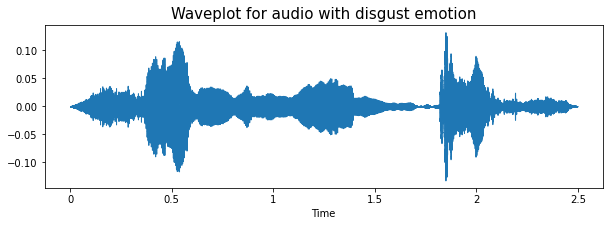

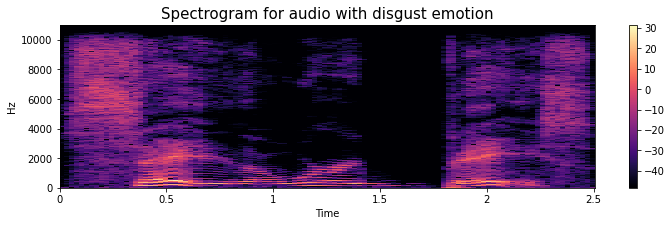

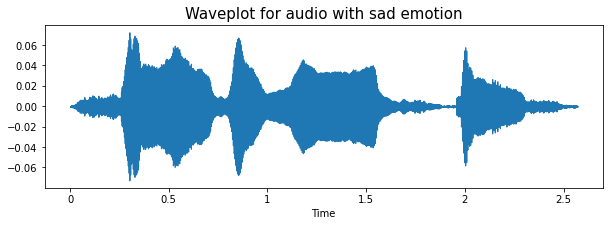

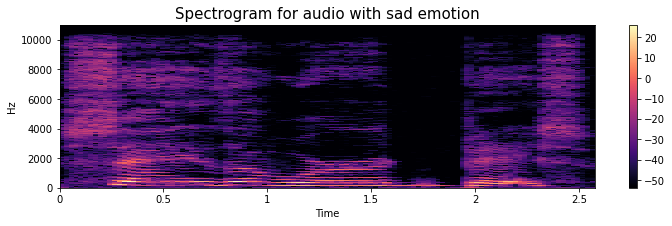

In [ ]:
emotion='disgust'
path = f'{FILE_DIR}/OAF_base_disgust.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
emotion='sad'
path = f'{FILE_DIR}/OAF_base_sad.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

In [ ]:
# Проверка формирования набора признаков
feature_set = stack_features(features)
feature_set.shape

(108, 37)

In [ ]:
# Функция формирования набора признаков и метки класса для аудиофайла

def get_feature_list_from_file(class_index,  # индекс класса файла song_name
                               song_name    # имя аудиофайла
                               ):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(class_index, CLASS_COUNT)

    return feature_set, y_label

In [ ]:
# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file(class_index,  # индекс класса аудиофайла
                 filename #имя файла
                 ):
    x_list = []
    y_list = []
    class_name = CLASS_LIST[class_index]

    # Извлечение имени произведения
    song_name = filename

    # Выборка признаков и метки класса для произведения
    feature_set, y_label = get_feature_list_from_file(class_index, 
                                                        song_name)

    # Добавление данных в наборы
    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    # Возврат имени файла и numpy-массивов призанков и меток класса
    return song_name, \
           np.array(x_list).astype('float32'), \
           np.array(y_list).astype('float32')

In [ ]:
import re
# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data():

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    file_list = os.listdir(FILE_DIR)
 
    for index, item in enumerate(file_list):
      if item.endswith(".wav"):
        m = re.match('^.AF_.*?_(.*?)\.\S*$', item)
        class_index = CLASS_LIST.index(m[1])
        _, file_x_data, file_y_data = process_file(class_index, f'{FILE_DIR}/{item}')
        x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
        y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])
        if index>0 and index%500==0: 
          print('{} файлов обработанно'.format(index))

    # Вывод информации о готовности обработки датасета
    print(f'Датасет готов -> {round(time.time() - curr_time)} c')

    # Возврат массивов набора данных
    return x_data, y_data

In [ ]:
# Формирование тренировочного (основного) набора данных
x_train_data, y_train_data = extract_data()

500 файлов обработанно
1000 файлов обработанно
1500 файлов обработанно
2000 файлов обработанно
2500 файлов обработанно
Датасет готов -> 505 c


In [ ]:
# Сохранение/восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов
with open('/content/audio_data.pickle', 'wb') as f:
    pickle.dump((x_train_data, y_train_data), f)

with open('/content/audio_data.pickle', 'rb') as f:
    x_train_data, y_train_data = pickle.load(f)

In [ ]:
# Вывод номеров классов для проверки правильности заполнения
# Номера классов идут последовательно крупными блоками
print(np.argmax(y_train_data, axis=1))

[0 0 0 ... 2 2 2]


In [ ]:
# Вывод формы данных обучающего набора
print(x_train_data.shape, x_train_data.dtype)
print(y_train_data.shape, y_train_data.dtype)

(249251, 37) float32
(249251, 7) float32


In [ ]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
x_scaler = StandardScaler()
x_train_data_scaled = x_scaler.fit_transform(x_train_data)

In [ ]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения
x_train, x_val, y_train, y_val = train_test_split(x_train_data_scaled,
                                                  y_train_data,
                                                  stratify=y_train_data,
                                                  test_size=VALIDATION_SPLIT)

In [ ]:
# Проверка нормирования
print(x_train[0])

[ 3.386062    0.51245445 -0.727552    0.2148955   0.7638353   1.6127242
 -1.2751458  -1.5533986   1.7338461  -0.9374419  -1.3003327  -1.3194399
 -0.42280295 -0.30081752 -1.8749352  -0.3135514   1.1105365  -2.0098078
 -0.20011434 -1.1472405  -1.0302258   3.8151417   1.9912605   4.5116205
  2.8895724  -0.58231854 -0.20246091  1.830586   -0.02316853  0.20057613
  0.49189305 -0.18849157  1.98551    -0.40585157 -0.8136316  -0.85275656
 -0.7648562 ]


In [ ]:
# Проверка формы и типа данных обучающей и проверочной выборок
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(224325, 37) float32
(224325, 7) float32

(24926, 37) float32
(24926, 7) float32


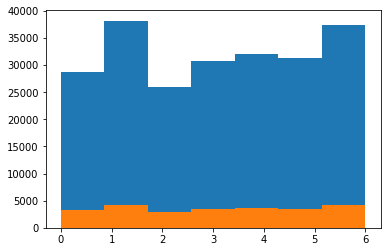

In [ ]:
# Проверка сбалансированности выборок по классам
plt.hist(np.argmax(y_train, axis=1), CLASS_COUNT)
plt.hist(np.argmax(y_val, axis=1), CLASS_COUNT)
plt.show()

##Модель нейронной сети

In [ ]:
# Функция сборки и обучения классификатора на полносвязных слоях

def create_train_classifier(in_shape,       # форма входных данных модели
                            epochs=50,      # количество эпох обучения
                            batch_size=512  # размер батча
                            ):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=in_shape))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(CLASS_COUNT, activation='softmax'))

    # Компиляция модели
    model.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()

    # Обучение модели
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графика точности распознавания на обучающей и проверочной выборках
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    plt.xticks(range(epochs))
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               9728      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

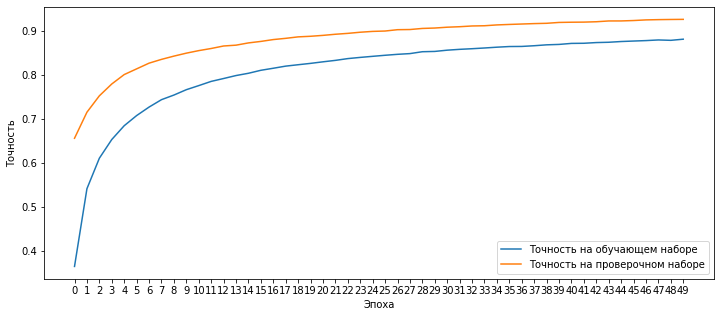

In [ ]:
model = create_train_classifier(x_train.shape[1:])

In [ ]:
# Сохранение/восстановление модели и выборок
model.save('/content/model_audio.h5')
with open('/content/audio_train_val.pickle', 'wb') as f:
    pickle.dump((x_train, y_train, x_val, y_val, x_scaler), f)

model = load_model('/content/model_audio.h5')
with open('/content/audio_train_val.pickle', 'rb') as f:
    x_train, y_train, x_val, y_val, x_scaler = pickle.load(f)

##Проверка точности предсказаний модели

###Проверка на данных тестовой выборки

In [ ]:
# Функция оценки точности модели на заданной выборке

def eval_model(model,  # обученная модель нейронной сети
               x,      # входные данные
               y_true  # выходные данные (верные ответы)
               ):
    loss, acc = model.evaluate(x, y_true)
    print(f'Ошибка: {loss}, точность: {acc}')

    # Построение матрицы ошибок
    y_pred = model.predict(x)
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок нормализованная')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()    

779/779 [==============================] - 2s 2ms/step - loss: 0.2110 - accuracy: 0.9272
Ошибка: 0.2109546661376953, точность: 0.9271844625473022
779/779 [==============================] - 1s 2ms/step


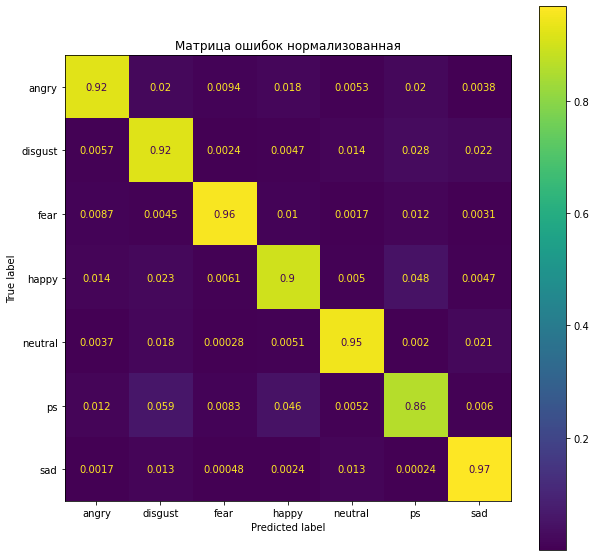

In [ ]:
# Оценка точности сети на проверочной выборке
eval_model(model, x_val, y_val)

**Вывод: Пока точность модели не достаточна, попробуем исследовать и подобрать значимые параметры**

##Методика подбора значимых параметров для обучения модели

In [ ]:
# Функция создания и обучения упрощенной архитектуры классификатора

def create_train_small_classifier(index_list,       # список номеров признаков в списке
                                  x_train=x_train,  # обучающая выборка - вход
                                  y_train=y_train,  # обучающая выборка - выход
                                  x_val=x_val,      # проверочная выборка - вход
                                  y_val=y_val,      # проверочная выборка - выход
                                  epochs=120,       # количество эпох обучения
                                  batch_size=2048,  # размер батча
                                  verbose=0         # подробность вывода при обучении
                                  ):
    # Сборка модели
    model = Sequential()
    model.add(Dense(200, activation='elu', input_shape=(len(index_list),)))
    model.add(Dense(7, activation='softmax'))

    model.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # Обучение модели на подмножестве признаков
    history = model.fit(x_train[:, index_list],
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=verbose,
                        validation_data=(x_val[:, index_list], y_val))

    # Вывод графика точности распознавания на обучающей и проверочной выборках
    plt.figure(figsize=(12,5))
    plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    plt.xticks(range(0, epochs, 7))
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()
    print('Точность в конце обучения:',
          history.history['accuracy'][-1],
          history.history['val_accuracy'][-1])
    
    return model

В функции `get_features()` признаки добавляются в следующем порядке индексов:

* **0**: 'rmse' - Среднеквадратическая амплитуда;
* **1**: 'spct' - Спектральный центроид;
* **2**: 'spbw' - Ширина полосы частот;
* **3**: 'roff' - Спектральный спад частоты;
* **4**: 'zcr' - Пересечения нуля;
* **5-24**: 'mfcc' - Мел-кепстральные коэффициенты (20 признаков);
* **25-36**: 'stft' - Хромаграмма (12 признаков).

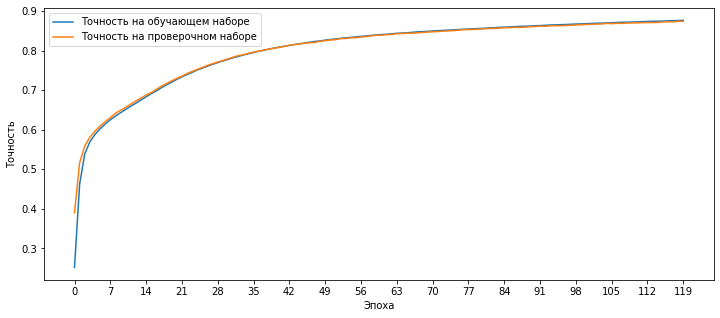

Точность в конце обучения: 0.876255452632904 0.8739469051361084


In [ ]:
# Обучение малой модели: все параметры
model_small = create_train_small_classifier(range(0, 37))

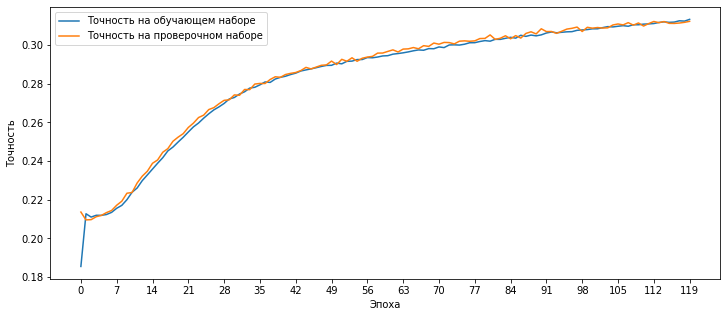

Точность в конце обучения: 0.3133489489555359 0.31232449412345886


In [ ]:
# Обучение малой модели: все параметры кроме мел-коэффициентов и хромаграммы
model_small = create_train_small_classifier(range(0, 5))

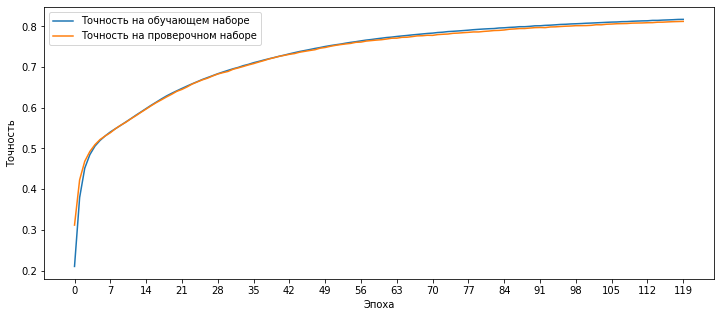

Точность в конце обучения: 0.8170823454856873 0.8120837807655334


In [ ]:
# Обучение малой модели: только мел-коэффициенты
model_small = create_train_small_classifier(range(5, 25))

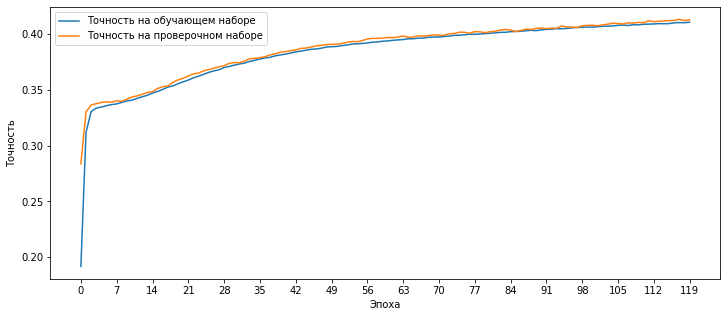

Точность в конце обучения: 0.4107433557510376 0.41290217638015747


In [ ]:
# Обучение малой модели: только хромаграмма
model_small = create_train_small_classifier(range(25, 37))

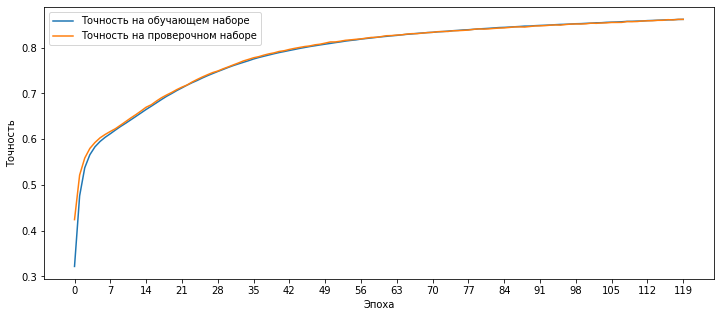

Точность в конце обучения: 0.8618878722190857 0.86183100938797


In [ ]:
# Обучение малой модели: мел-коэффициенты и хромаграмма
model_small = create_train_small_classifier(range(5, 37))

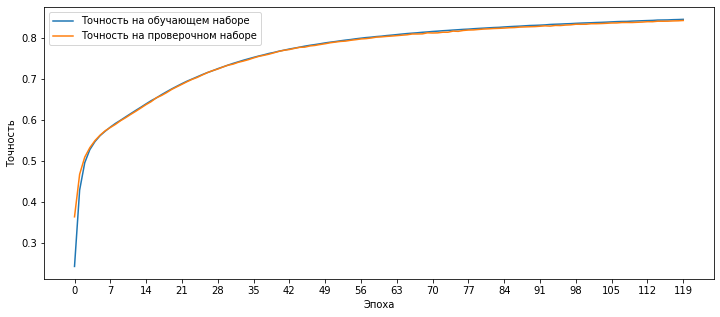

Точность в конце обучения: 0.8460893630981445 0.8432961702346802


In [ ]:
# Обучение малой модели: все параметры кроме хромаграммы
model_small = create_train_small_classifier(range(0, 25))

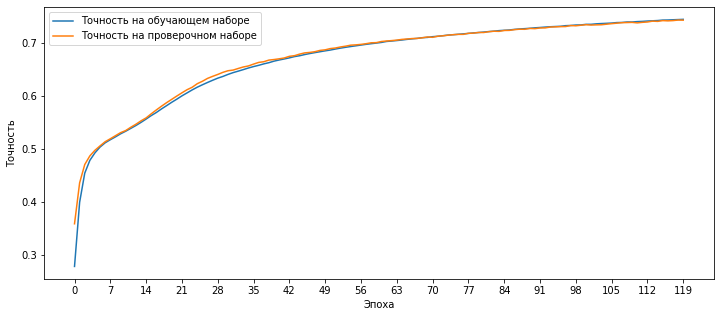

Точность в конце обучения: 0.7451955676078796 0.7436813116073608


In [ ]:
# Обучение малой модели: все параметры с шагом 2
model_small = create_train_small_classifier(range(0, 37, 2))

**Вывод: явно выраженных параметров, от которым мы могли бы избавиться для нашей модели не выявлено, попробуем другие способы повышения точности модели**

##Пример аугментации данных для повышения точности классификации

In [ ]:
# Все операции в данном блоке выполняются поэлементно; в результате получаются массивы той же формы

# Квадрат значений
x_train_data_sqr = x_train_data ** 2

# Квадратный корень из модулей значений
x_train_data_sqrt = np.abs(x_train_data) ** 0.5

# Обратная величина
x_train_data_inv = 1. / x_train_data

# 2 в степени каждого значения
x_train_data_exp = 2. ** x_train_data

# Формирование нового тренировочного набора данных
x_train_data_aug = np.hstack([x_train_data, x_train_data_sqr, x_train_data_sqrt, x_train_data_exp])

# Проверка формы данных нового набора
print(x_train_data_aug.shape)

(249251, 148)


In [ ]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
# Замена всех бесконечных значений на 0, иначе нормирование невозможно
x_train_data_aug[np.abs(x_train_data_aug) == math.inf] = 0

x_scaler_aug = StandardScaler()
x_train_data_aug_scaled = x_scaler_aug.fit_transform(x_train_data_aug)

In [ ]:
# Разделение набора данных на обучающую и проверочную выборки
x_train_aug, x_val_aug, y_train_aug, y_val_aug = train_test_split(x_train_data_aug_scaled,
                                                                  y_train_data,
                                                                  test_size=VALIDATION_SPLIT)

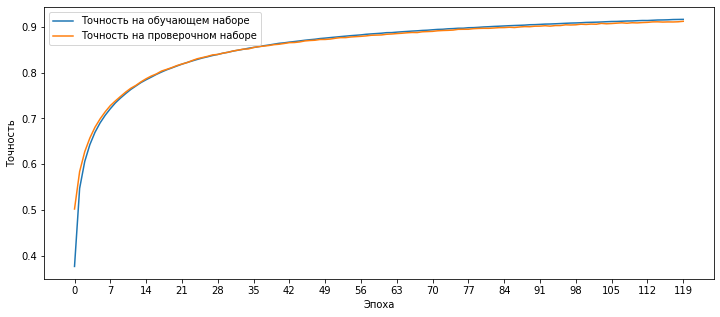

Точность в конце обучения: 0.9166164994239807 0.9123806357383728


In [ ]:
# Обучение малой модели: все параметры + синтетически добавленные (аугментированные)
model_small = create_train_small_classifier(range(x_train_aug.shape[1]),
                                            x_train=x_train_aug,
                                            y_train=y_train_aug,
                                            x_val=x_val_aug,
                                            y_val=y_val_aug)

**Вывод: аугментация модели повысила точность на малой модели, возможно это сработает и на основной**

### Попробуем сетевую модель, для повышения точности 

In [ ]:
# Функция компиляции и обучения модели с одними и теми же параметрами

def compile_train(model,           # модель нейронной сети
                  epochs=100,      # количество эпох обучения
                  batch_size=4096  # размер батча
                  ):
    # Компиляция
    model.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # Обучение
    history = model.fit(x_train_aug,
                        y_train_aug,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val_aug, y_val_aug))

    # Вывод графика обучения
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.show()

Epoch 1/100
55/55 [==============================] - 4s 25ms/step - loss: 1.2376 - accuracy: 0.5646 - val_loss: 1.4364 - val_accuracy: 0.5185
Epoch 2/100
55/55 [==============================] - 1s 19ms/step - loss: 0.7109 - accuracy: 0.7619 - val_loss: 1.2731 - val_accuracy: 0.5767
Epoch 3/100
55/55 [==============================] - 1s 19ms/step - loss: 0.5589 - accuracy: 0.8144 - val_loss: 1.1510 - val_accuracy: 0.6116
Epoch 4/100
55/55 [==============================] - 1s 19ms/step - loss: 0.4704 - accuracy: 0.8434 - val_loss: 1.0586 - val_accuracy: 0.6358
Epoch 5/100
55/55 [==============================] - 1s 19ms/step - loss: 0.4115 - accuracy: 0.8625 - val_loss: 0.9563 - val_accuracy: 0.6722
Epoch 6/100
55/55 [==============================] - 1s 19ms/step - loss: 0.3674 - accuracy: 0.8772 - val_loss: 0.8534 - val_accuracy: 0.7065
Epoch 7/100
55/55 [==============================] - 1s 19ms/step - loss: 0.3347 - accuracy: 0.8881 - val_loss: 0.7482 - val_accuracy: 0.7457
Epoch 

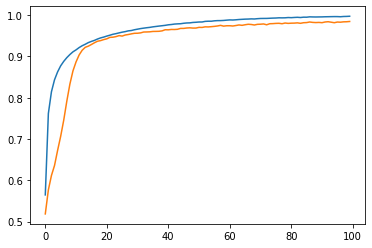

In [ ]:
# Сеть с измененным количеством нейронов в слоях и нормализацией после каждого слоя

input1 = Input(x_train_aug.shape[1:])

x1 = Dense(256, activation="elu")(input1)
x1 = BatchNormalization()(x1)
x1 = Dense(256, activation="elu")(x1)
x1 = BatchNormalization()(x1)

x2 = Dense(256, activation="elu")(input1)
x2 = BatchNormalization()(x2)
x2 = Dense(40, activation="softmax")(x2)
x2 = BatchNormalization()(x2)

x3 = Dense(256, activation="elu")(input1)
x3 = BatchNormalization()(x3)
x3 = Dense(200, activation="softmax")(x3)
x3 = BatchNormalization()(x3)

x4 = Dense(40, activation="softmax")(input1)
x4 = BatchNormalization()(x4)

x5 = Dense(200, activation="softmax")(input1)
x5 = BatchNormalization()(x5)

x6 = Dense(10, activation="softmax")(input1)
x6 = BatchNormalization()(x6)

x7 = Dense(256, activation="elu")(input1)
x7 = BatchNormalization()(x7)
x7 = Dense(10, activation="softmax")(x7)
x7 = BatchNormalization()(x7)

x = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = BatchNormalization()(x)
x = Dense(256, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(7, activation='softmax')(x)

model = Model(input1, x)

compile_train(model)

In [ ]:
# Сохранение/восстановление модели
model.save('/content/model_audio_advanced.h5')
model = load_model('/content/model_audio_advanced.h5')

##Проверка точности предсказаний модели

###Проверка на данных тестовой выборки

779/779 [==============================] - 3s 4ms/step - loss: 0.0530 - accuracy: 0.9847
Ошибка: 0.053047578781843185, точность: 0.9846746325492859
779/779 [==============================] - 2s 3ms/step


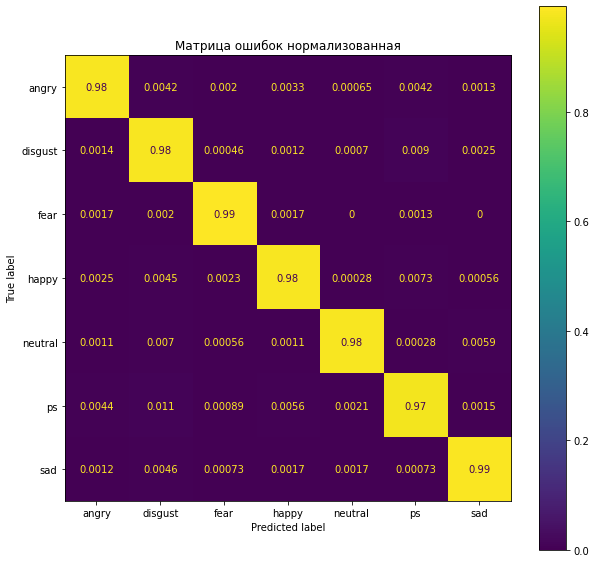

In [ ]:
# Оценка точности сети на проверочной выборке
eval_model(model, x_val_aug, y_val_aug)

**Вывод: требуемая точность модели достигнута, проверим точность модели на тестовых данных из другого датасета**

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l12/archive.zip', None, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l12/archive.zip
To: /content/archive.zip
100%|██████████| 113M/113M [00:05<00:00, 19.6MB/s]


'archive.zip'

In [ ]:
# Распаковка архива на локальный диск colab
!unzip -qo archive.zip

# Проверка выгруженных папок
!ls ALL 

DC_a01.wav  DC_n21.wav	 JE_f11.wav   JK_a01.wav  JK_n21.wav   KL_f11.wav
DC_a02.wav  DC_n22.wav	 JE_f12.wav   JK_a02.wav  JK_n22.wav   KL_f12.wav
DC_a03.wav  DC_n23.wav	 JE_f13.wav   JK_a03.wav  JK_n23.wav   KL_f13.wav
DC_a04.wav  DC_n24.wav	 JE_f14.wav   JK_a04.wav  JK_n24.wav   KL_f14.wav
DC_a05.wav  DC_n25.wav	 JE_f15.wav   JK_a05.wav  JK_n25.wav   KL_f15.wav
DC_a06.wav  DC_n26.wav	 JE_h01.wav   JK_a06.wav  JK_n26.wav   KL_h01.wav
DC_a07.wav  DC_n27.wav	 JE_h02.wav   JK_a07.wav  JK_n27.wav   KL_h02.wav
DC_a08.wav  DC_n28.wav	 JE_h03.wav   JK_a08.wav  JK_n28.wav   KL_h03.wav
DC_a09.wav  DC_n29.wav	 JE_h04.wav   JK_a09.wav  JK_n29.wav   KL_h04.wav
DC_a10.wav  DC_n30.wav	 JE_h05.wav   JK_a10.wav  JK_n30.wav   KL_h05.wav
DC_a11.wav  DC_sa01.wav  JE_h06.wav   JK_a11.wav  JK_sa01.wav  KL_h06.wav
DC_a12.wav  DC_sa02.wav  JE_h07.wav   JK_a12.wav  JK_sa02.wav  KL_h07.wav
DC_a13.wav  DC_sa03.wav  JE_h08.wav   JK_a13.wav  JK_sa03.wav  KL_h08.wav
DC_a14.wav  DC_sa04.wav  JE_h09.wav   JK_a14.wav

In [ ]:
# Функция формирования набора данных из файлов всех классов
TEST_FILE_DIR = 'ALL'

def extract_test_data():

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    file_list = os.listdir(TEST_FILE_DIR)
 
    for index, item in enumerate(file_list):
      if item.endswith(".wav"):
        if item[-8:-6]=='_a':
          emotion='angry'
        elif item[-8:-6]=='_d':
          emotion='disgust'
        elif item[-8:-6]=='_f':
          emotion='fear'
        elif item[-8:-6]=='_h':
          emotion='happy'
        elif item[-8:-6]=='_n':
          emotion='neutral'
        elif item[-8:-6]=='sa':
          emotion='sad'
        elif item[-8:-6]=='su':
          emotion='ps'
        class_index = CLASS_LIST.index(emotion)
        _, file_x_data, file_y_data = process_file(class_index, f'{TEST_FILE_DIR}/{item}')
        x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
        y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])
        if index>0 and index%500==0: 
          print('{} файлов обработанно'.format(index))

    # Вывод информации о готовности обработки датасета
    print(f'Датасет готов -> {round(time.time() - curr_time)} c')
    # Возврат массивов набора данных
    return x_data, y_data

In [ ]:
# Формирование тестового набора данных
x_test, y_test = extract_test_data()

Датасет готов -> 147 c


In [ ]:
# Все операции в данном блоке выполняются поэлементно; в результате получаются массивы той же формы

# Квадрат значений
x_test_data_sqr = x_test ** 2

# Квадратный корень из модулей значений
x_test_data_sqrt = np.abs(x_test) ** 0.5

# Обратная величина
x_test_data_inv = 1. / x_test

# 2 в степени каждого значения
x_test_data_exp = 2. ** x_test

# Формирование нового тренировочного набора данных
x_test_data_aug = np.hstack([x_test, x_test_data_sqr, x_test_data_sqrt, x_test_data_exp])

# Проверка формы данных нового набора
print(x_train_data_aug.shape)

(249251, 148)


In [ ]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
# Замена всех бесконечных значений на 0, иначе нормирование невозможно
x_test_data_aug[np.abs(x_test_data_aug) == math.inf] = 0

x_scaler_aug = StandardScaler()
x_test_data_aug_scaled = x_scaler_aug.fit_transform(x_test_data_aug)

2488/2488 [==============================] - 9s 4ms/step - loss: 13.1100 - accuracy: 0.1479
Ошибка: 13.10995864868164, точность: 0.14793553948402405
2488/2488 [==============================] - 7s 3ms/step


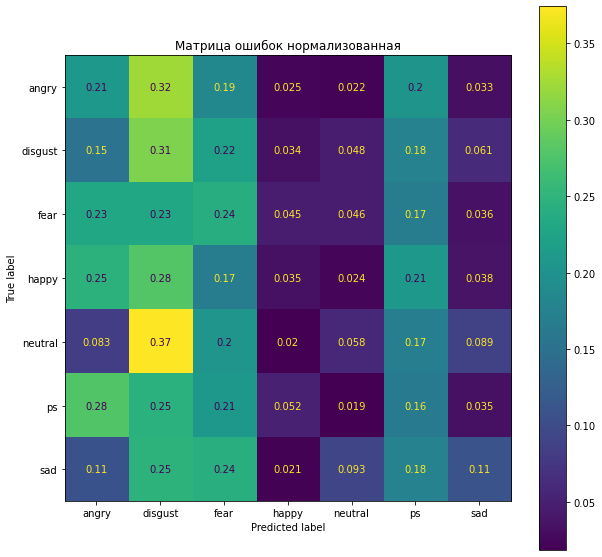

In [ ]:
# Оценка точности сети на тестовой выборке
eval_model(model, x_test_data_aug_scaled, y_test)

###С прикладной точки зрения более верно проверять точность на звуковых файлах

In [ ]:
# Функция формирования подвыборки признаков и меток класса для одного файла

def process_test_file(class_index,  # индекс класса аудиофайла
                 filename #имя файла
                 ):
    x_list = []
    y_list = []
    class_name = CLASS_LIST[class_index]

    # Извлечение имени произведения
    song_name = filename

    # Выборка признаков и метки класса для произведения
    feature_set, y_label = get_feature_list_from_file(class_index, 
                                                        song_name)

    # Добавление данных в наборы
    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    # Возврат имени файла и numpy-массивов призанков и меток класса
    return song_name, \
           np.array(x_list).astype('float32'), \
           np.array(y_list).astype('float32')

In [ ]:
# Классификация файла и визуализация предсказания модели для него

def classify_test_file(model,        # обученная модель классификатора
                  x_scaler,     # настроенный нормировщих входных данных
                  class_index,  # верный индекс класса аудиофайла
                  file_index    # индекс (порядковый номер) аудиофайла в папке
                  ):
    # Подготовка выборки данных файла произведения
    song_name, file_x_data, file_y_data = process_test_file(class_index, file_index)
    # аугмерация данных
    file_x_data_sqr = file_x_data ** 2
    file_x_data_sqrt = np.abs(file_x_data) ** 0.5
    file_x_data_inv = 1. / file_x_data
    file_x_data_exp = 2. ** file_x_data
    # Формирование нового тренировочного набора данных
    file_x_data_aug = np.hstack([file_x_data, file_x_data_sqr, file_x_data_sqrt, file_x_data_exp])
    # Замена всех бесконечных значений на 0, иначе нормирование невозможно
    file_x_data_aug[np.abs(file_x_data_aug) == math.inf] = 0
    # Нормирование аугментированных признаков уже настроенным нормировщиком
    file_x_data_aug = x_scaler_aug.transform(file_x_data_aug)

    print('Файл:', song_name)
    print('Векторы для предсказания:', file_x_data_aug.shape)

    # Вычисление предсказания по выборке
    predict = model.predict(file_x_data_aug)
    # Определение среднего предсказания (голосование)
    predict_mean = predict.mean(axis=0)
    # Определение индекса класса по результату голосования
    predict_class_index = np.argmax(predict_mean)
    # Вычисление признака правильного предсказания
    predict_good = predict_class_index == class_index

    # Визуализация предсказания сети для файла
    plt.figure(figsize=(10,3))
    print('Классификация сети:', CLASS_LIST[predict_class_index], '-', 'ВЕРНО :-)' if predict_good else 'НЕВЕРНО.')
    plt.title('Среднее распределение векторов предсказаний')
    plt.bar(CLASS_LIST, predict_mean, color='g' if predict_good else 'r')
    plt.show()
    print('---------------------------------------------------------------')

    # Возврат результата предсказания
    return predict_class_index

In [ ]:
# Классификация и визуализация нескольких файлов каждого класса 

def classify_test_files(model,       # обученная модель классификатора
                        x_scaler,    # настроенный нормировщих входных данных
                        file_index,  # индекс аудиофайла, с которого начинать визуализацию
                        class_index, # индекс тестируемого класса
                        n_files):    # количество файлов для визуализации
    predict_all = 0
    predict_good = 0
    y_true = []
    y_pred = []
    for num in range(1, n_files+1):
      if num<=9:
        predict_class_index = classify_test_file(model, x_scaler, class_index, f'{TEST_FILE_DIR}/{file_index}0{num}.wav')
      else:
        predict_class_index = classify_test_file(model, x_scaler, class_index, f'{TEST_FILE_DIR}/{file_index}{num}.wav')
      y_true.append(class_index)
      y_pred.append(predict_class_index)
      predict_all += 1
      predict_good += (predict_class_index == class_index)

    # Расчет и вывод итогов классификации
    good_ratio = round(predict_good / predict_all * 100., 2)
    print(f'=== Обработано образцов: {predict_all}, из них распознано верно: {predict_good}, доля верных: {good_ratio}% ===')   

    # Построение матрицы ошибок без нормализации, покажет попадания в штуках
    cm = confusion_matrix(y_true, y_pred)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок по файлам аудио (не нормализованная)')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()

Файл: ALL/DC_a01.wav
Векторы для предсказания: (158, 148)
5/5 [==============================] - 0s 4ms/step
Классификация сети: disgust - НЕВЕРНО.


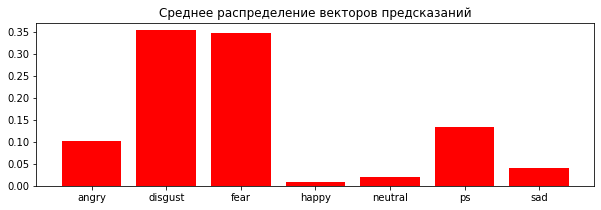

---------------------------------------------------------------
Файл: ALL/DC_a02.wav
Векторы для предсказания: (149, 148)
5/5 [==============================] - 0s 3ms/step
Классификация сети: disgust - НЕВЕРНО.


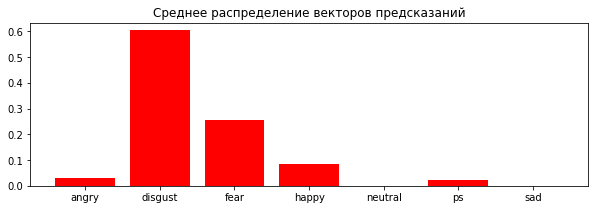

---------------------------------------------------------------
Файл: ALL/DC_a03.wav
Векторы для предсказания: (90, 148)
3/3 [==============================] - 0s 4ms/step
Классификация сети: fear - НЕВЕРНО.


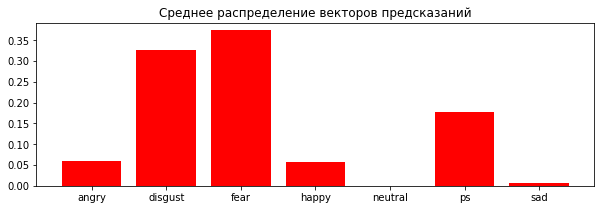

---------------------------------------------------------------
Файл: ALL/DC_a04.wav
Векторы для предсказания: (118, 148)
4/4 [==============================] - 0s 3ms/step
Классификация сети: disgust - НЕВЕРНО.


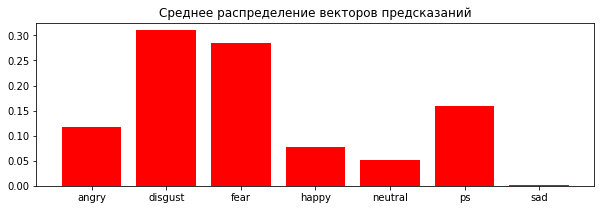

---------------------------------------------------------------
Файл: ALL/DC_a05.wav
Векторы для предсказания: (130, 148)
5/5 [==============================] - 0s 4ms/step
Классификация сети: fear - НЕВЕРНО.


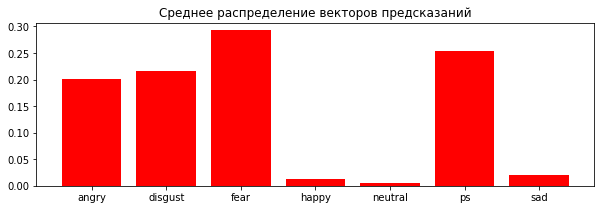

---------------------------------------------------------------
Файл: ALL/DC_a06.wav
Векторы для предсказания: (161, 148)
6/6 [==============================] - 0s 5ms/step
Классификация сети: disgust - НЕВЕРНО.


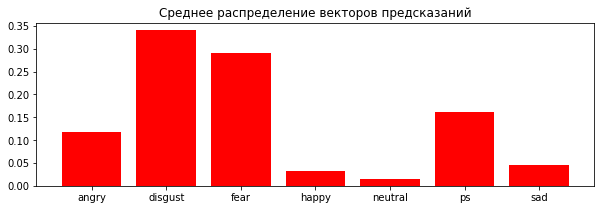

---------------------------------------------------------------
Файл: ALL/DC_a07.wav
Векторы для предсказания: (116, 148)
4/4 [==============================] - 0s 4ms/step
Классификация сети: fear - НЕВЕРНО.


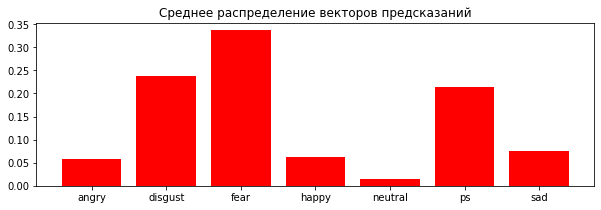

---------------------------------------------------------------
Файл: ALL/DC_a08.wav
Векторы для предсказания: (150, 148)
5/5 [==============================] - 0s 3ms/step
Классификация сети: angry - ВЕРНО :-)


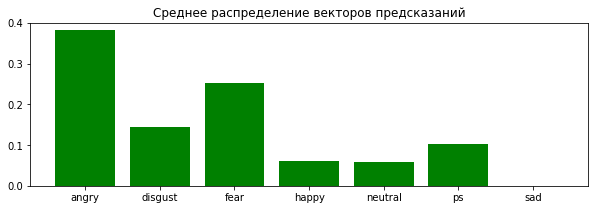

---------------------------------------------------------------
Файл: ALL/DC_a09.wav
Векторы для предсказания: (174, 148)
6/6 [==============================] - 0s 3ms/step
Классификация сети: disgust - НЕВЕРНО.


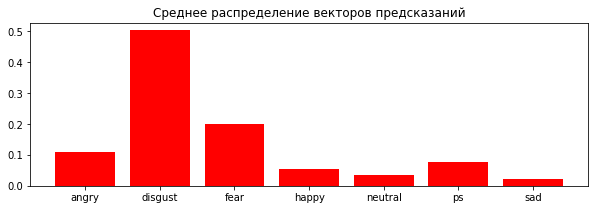

---------------------------------------------------------------
Файл: ALL/DC_a10.wav
Векторы для предсказания: (199, 148)
7/7 [==============================] - 0s 4ms/step
Классификация сети: disgust - НЕВЕРНО.


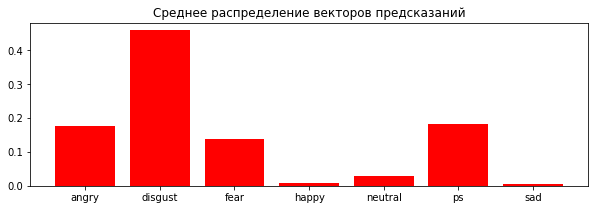

---------------------------------------------------------------
Файл: ALL/DC_a11.wav
Векторы для предсказания: (115, 148)
4/4 [==============================] - 0s 4ms/step
Классификация сети: ps - НЕВЕРНО.


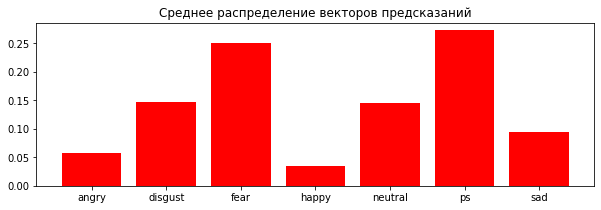

---------------------------------------------------------------
Файл: ALL/DC_a12.wav
Векторы для предсказания: (143, 148)
5/5 [==============================] - 0s 4ms/step
Классификация сети: disgust - НЕВЕРНО.


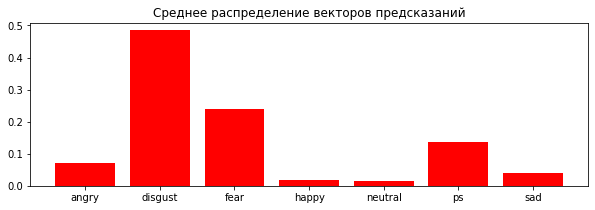

---------------------------------------------------------------
Файл: ALL/DC_a13.wav
Векторы для предсказания: (202, 148)
7/7 [==============================] - 0s 4ms/step
Классификация сети: disgust - НЕВЕРНО.


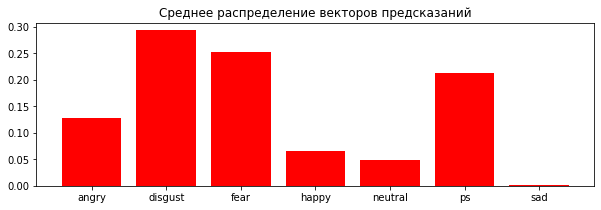

---------------------------------------------------------------
Файл: ALL/DC_a14.wav
Векторы для предсказания: (233, 148)
8/8 [==============================] - 0s 3ms/step
Классификация сети: disgust - НЕВЕРНО.


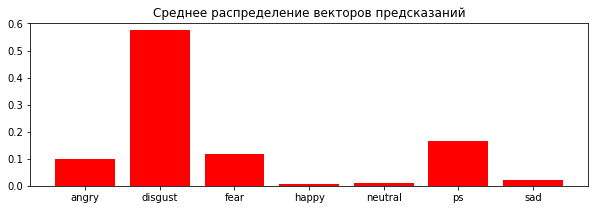

---------------------------------------------------------------
Файл: ALL/DC_a15.wav
Векторы для предсказания: (212, 148)
7/7 [==============================] - 0s 3ms/step
Классификация сети: angry - ВЕРНО :-)


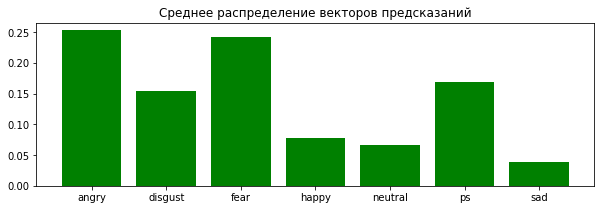

---------------------------------------------------------------
=== Обработано образцов: 15, из них распознано верно: 2, доля верных: 13.33% ===


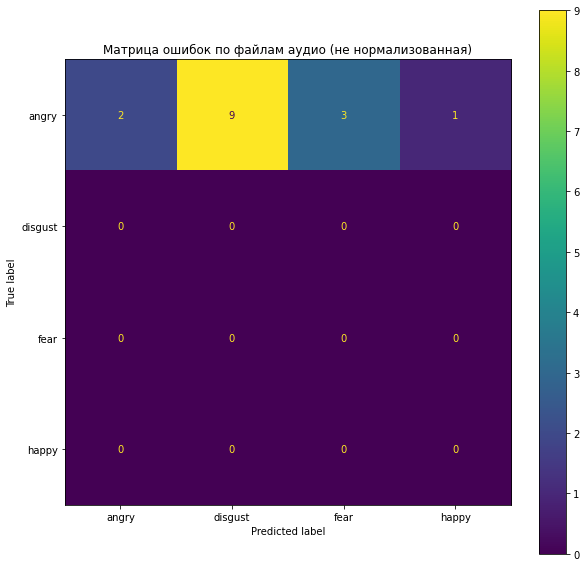

In [ ]:
# Визуализация классификации файлов из тренировочного набора
classify_test_files(model, x_scaler_aug, 'DC_a', 0, 15)

**Вывод: модель хорошо себя показывает на тренировочном датасете, но плохо на тестовом. Вполне возможно это связано с тем что на тренировочном однотипные примеры, и для улучшения результата необходимо дотренировать модель на большем количестве разнотипных примеров из нескольких источников**